# Загрузка данных

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objs as go
import numpy as np

In [62]:
df = pd.read_csv('T_games_dataset.csv')

Размеры перед предобработкой:

In [63]:
n_purchases, n_users = df.shape[0], df['client_id'].nunique()
print('Number of purchases: {}'.format(n_purchases))
print('Number of users: {}'.format(n_users))

Number of purchases: 88699
Number of users: 41298


In [64]:
df['good_type'] = df['good_name'].apply(
    lambda x: 'DLC' if 'dlc' in x.lower() else 'Game')
df['is_DLC'] = df['good_type'] == 'DLC'

bundle_tags = ['edition', 'pack', 'collection', 'bundle', 'antology']

df['is_bundle'] = df['good_name'].apply(lambda x: (
    any(tag in x.lower() for tag in bundle_tags)) and ('dlc' not in x.lower()))
bundle_purchases = df[df['is_bundle']].copy()
bundle_purchases['is_DLC'] = True
bundle_purchases['good_name'] = bundle_purchases['good_name'].apply(
    lambda x: x + ' (dlc from bundle)')
df = pd.concat([df, bundle_purchases], axis=0)

edu_lvl_grade = {'SCH': 1, 'UGR': 2, 'GRD': 3, 'PGR': 4, 'ACD': 5}
edu_lvl_by_grade = {v: k for k, v in edu_lvl_grade.items()}

df['edu_lvl_grade'] = df['education_level'].map(edu_lvl_grade)

min_age_by_id = df.groupby('client_id')['age'].min()
df['min_age'] = df['client_id'].map(min_age_by_id)

max_age_by_id = df.groupby('client_id')['age'].max()
df['max_age'] = df['client_id'].map(max_age_by_id)

highest_edu_lvl_by_id = df.groupby('client_id')['education_level'].apply(
    lambda x: edu_lvl_by_grade[x.map(edu_lvl_grade).max()])

df['edu_lvl_grade'] = df['client_id'].map(edu_lvl_grade)

count_genders_by_id = df.groupby('client_id').apply(
    lambda x: x['gender_cd'].nunique())

edu_lvls_by_id = df.groupby('client_id')['education_level'].apply(
    lambda x: x.drop_duplicates().tolist())

age_by_edu_lvl_treshold = {
    'SCH': 0, 'UGR': 16, 'GRD': 22, 'PGR': 26, 'ACD': 31}

In [65]:
df = df[df['max_age'] == df['min_age']]
df = df[df['client_id'].map(count_genders_by_id) == 1]
df.drop_duplicates(subset=['client_id', 'good_name'], inplace=True)
client_ids = df['client_id'].drop_duplicates()

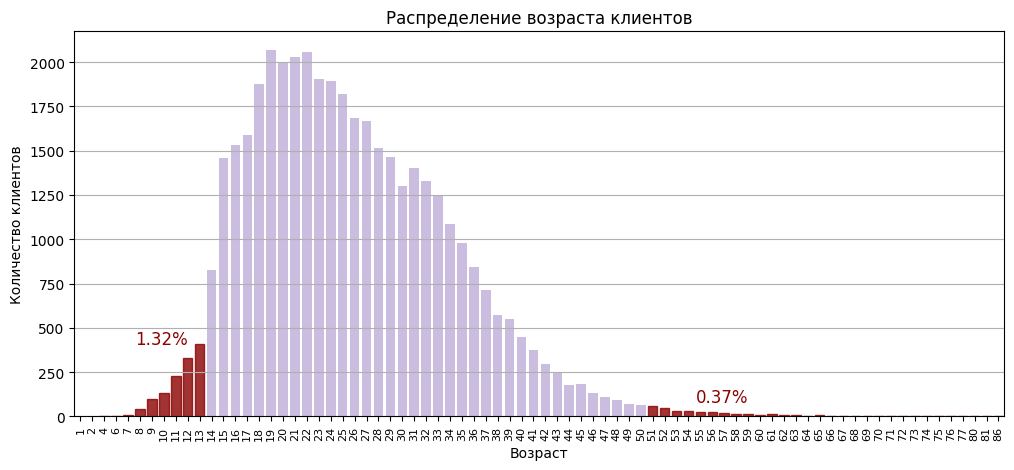

In [66]:
tmp_df = pd.DataFrame({'age' : client_ids.map(min_age_by_id)})
bars = tmp_df.groupby('age').size()
plt.figure(figsize=(12, 5))
plt.grid(True)
ax = sns.barplot(x=bars.index, y=bars.values, color='#bba5e1', alpha=0.8)

older_than_55 = tmp_df[tmp_df['age'] > 50].shape[0] / df.shape[0]
younger_than_14 = tmp_df[tmp_df['age'] < 14].shape[0] / df.shape[0]

for b in ax.patches:
    if 1 <= b.get_x() < 10 or 47 <= b.get_x():
        b.set_color('darkred')
    if 50 <= b.get_x() <= 51:
        ax.annotate(f'{older_than_55 * 100:.2f}%', (b.get_x() + 1,
                    b.get_height() + 50), fontsize=12, color='darkred')
    if 9 <= b.get_x() <= 10:
        ax.annotate(f'{younger_than_14 * 100:.2f}%', (b.get_x() -
                    5, b.get_height()), fontsize=12, color='darkred')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
plt.title('Распределение возраста клиентов')
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов')
plt.show()

In [67]:
df = df[df['age'].between(14, 50)]

client_ids = df['client_id'].drop_duplicates()

In [68]:
print(f'Number of rows: {len(df)}')
print(f'Unique clients: {len(client_ids)}')

Number of rows: 92406
Unique clients: 39635


In [69]:
def correct_edu_lvl(cliend_id):
    age = min_age_by_id[cliend_id]
    max_lvl = max([edu_lvl_grade[lvl] for lvl in edu_lvls_by_id[cliend_id]])
    while age < age_by_edu_lvl_treshold[edu_lvl_by_grade[max_lvl]]:
        max_lvl -= 1
    return edu_lvl_by_grade[max_lvl]


df['education_level'] = df['client_id'].map(correct_edu_lvl)

In [70]:
mean_income_by_id = df.groupby('client_id')['monthly_income_amt'].mean()

min_income_by_id = df.groupby('client_id')['monthly_income_amt'].min()

age_by_id = df.groupby('client_id')['age'].min()

dlc_to_all_ratio_by_id = df.groupby('client_id')['is_DLC'].mean()

In [71]:
client_ids = client_ids[client_ids.map(min_income_by_id) > 0]

In [72]:
right_treshold = client_ids.map(mean_income_by_id).quantile(0.99)
client_ids = client_ids[client_ids.map(mean_income_by_id) < right_treshold]
print(f'Right treshold: {right_treshold}')

Right treshold: 444003.7400000015


In [73]:
print(f'Rows: {len(df)}, {len(df) / n_purchases * 100:.2f}% from original')
print(
    f'Clients: {len(client_ids)}, {len(client_ids) / n_users * 100:.2f}% from original')

Rows: 92406, 104.18% from original
Clients: 32145, 77.84% from original


# Анализ

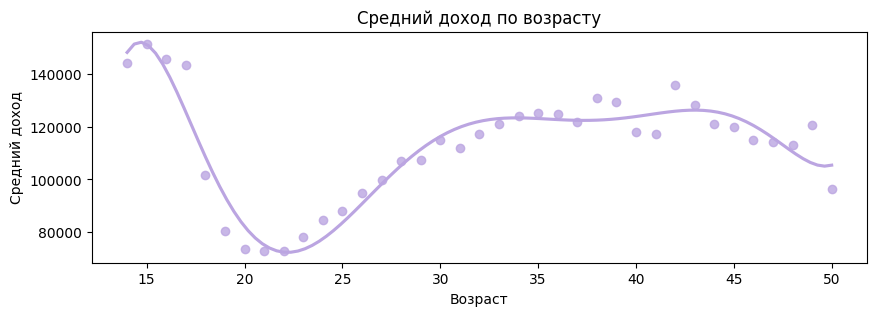

In [74]:
plt.figure(figsize=(10, 3))
df1 = pd.DataFrame({'age': client_ids.map(min_age_by_id),
                   'mean income': client_ids.map(mean_income_by_id)})
df1 = df1[df1['age'].between(14, 50)]
df2 = df1.groupby('age')['mean income'].mean().reset_index()
sns.regplot(x='age', y='mean income', data=df2, order=7,
            ci=None, color='#bba5e1')
plt.xlabel('Возраст')
plt.ylabel('Средний доход')
plt.title('Средний доход по возрасту')
plt.show()

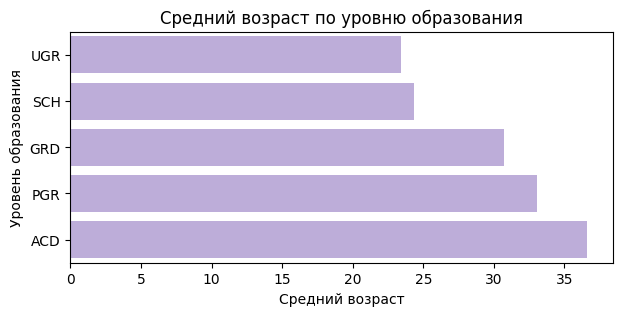

In [103]:
plt.figure(figsize=(7, 3))
df1 = pd.DataFrame({'age': client_ids.map(min_age_by_id),
                   'edu_lvl': client_ids.map(correct_edu_lvl)})
df2 = df1.groupby('edu_lvl')['age'].mean().sort_values().reset_index()

sns.barplot(x='age', y='edu_lvl', data=df2, color='#bba5e1')
plt.xlabel('Средний возраст')
plt.ylabel('Уровень образования')
plt.title('Средний возраст по уровню образования')
plt.show()

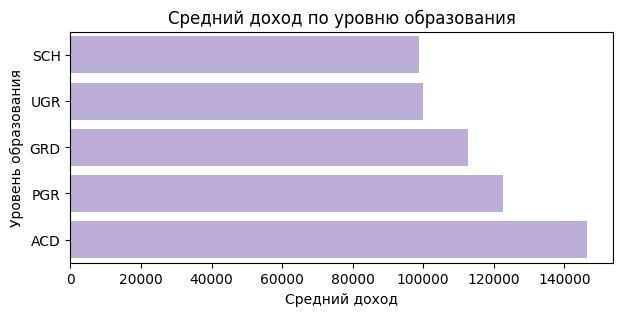

In [101]:
plt.figure(figsize=(7, 3))
df1 = pd.DataFrame({'edu_lvl': client_ids.map(correct_edu_lvl),
                   'monthly_income_amt': client_ids.map(mean_income_by_id)})
df2 = df1.groupby('edu_lvl')[
    'monthly_income_amt'].mean().sort_values().reset_index()
sns.barplot(x='monthly_income_amt', y='edu_lvl', data=df2, color='#bba5e1')
plt.xlabel('Средний доход')
plt.ylabel('Уровень образования')
plt.title('Средний доход по уровню образования')
plt.show()

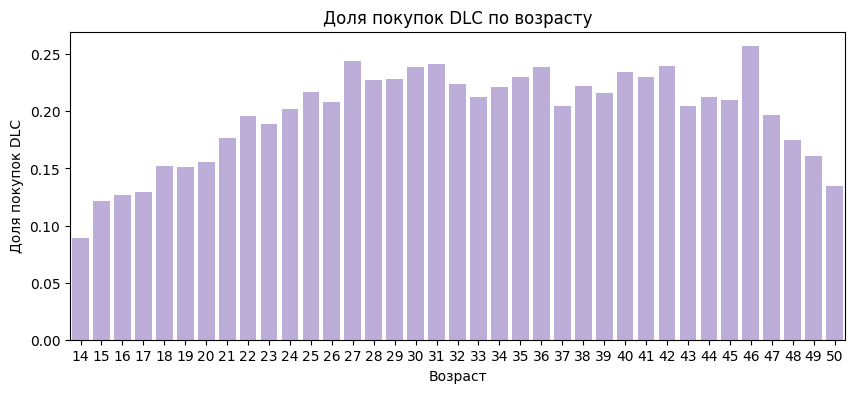

In [98]:
plt.figure(figsize=(10, 4))
df1 = pd.DataFrame({'age': client_ids.map(min_age_by_id),
                   'dlc_to_all_ratio': client_ids.map(dlc_to_all_ratio_by_id)})
df1 = df1[df1['age'].between(14, 50)]
df2 = df1.groupby('age')['dlc_to_all_ratio'].mean().reset_index()
sns.barplot(x='age', y='dlc_to_all_ratio', data=df2, color='#bba5e1')
plt.xlabel('Возраст')
plt.ylabel('Доля покупок DLC')
plt.title('Доля покупок DLC по возрасту');

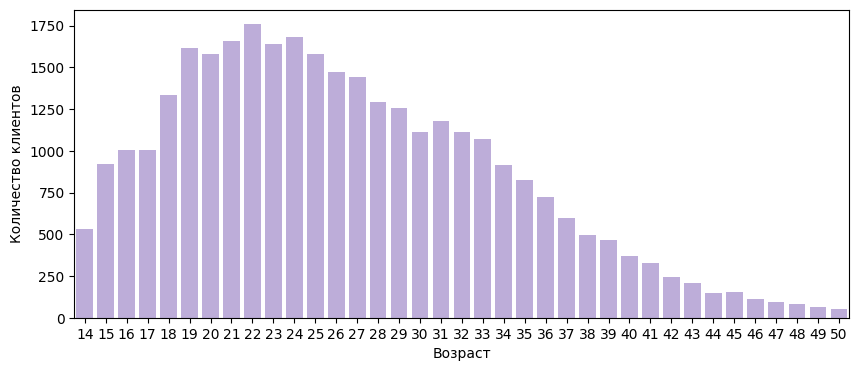

In [97]:
plt.figure(figsize=(10, 4))
sns.countplot(x=client_ids.map(min_age_by_id), color='#bba5e1')
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов');

In [85]:
def find_w0_w1(x, y):
    w1 = ((x - x.mean()) * (y - y.mean())).sum() / ((x - x.mean()) ** 2).sum()
    w0 = y.mean() - w1 * x.mean()
    return w0, w1

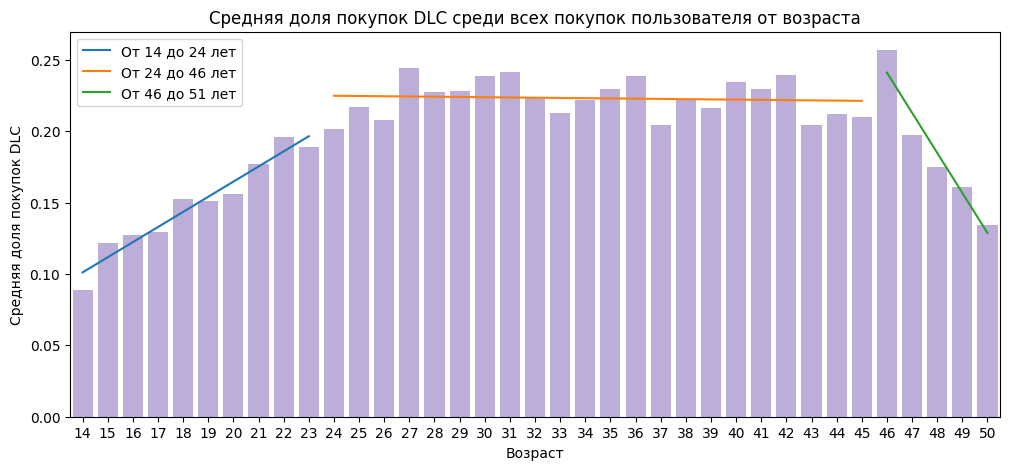

In [95]:
age_groups = [(14, 24), (24, 46), (46, 51)]

fig = plt.figure(figsize=(12, 5))

df1 = pd.DataFrame({'age': client_ids.map(min_age_by_id), 'dlc_to_all_ratio': client_ids.map(dlc_to_all_ratio_by_id)})

df1 = df1.groupby('age')['dlc_to_all_ratio'].mean().reset_index()

for min_age, max_age in age_groups:
    x = np.arange(min_age, max_age)
    y = df1[df1['age'].isin(x)]['dlc_to_all_ratio'].values
    w0, w1 = find_w0_w1(x, y)
    plt.plot(x - 14, w0 + w1 * np.array(x), label=f'От {min_age} до {max_age} лет')

plt.legend()

plt.title("Средняя доля покупок DLC среди всех покупок пользователя от возраста")

df1 = pd.DataFrame({'age': client_ids.map(min_age_by_id),
                   'dlc_to_all_ratio': client_ids.map(dlc_to_all_ratio_by_id)})
df1 = df1[df1['age'].between(14, 50)]
df2 = df1.groupby('age')['dlc_to_all_ratio'].mean().reset_index()
sns.barplot(x='age', y='dlc_to_all_ratio', data=df2, color='#bba5e1')
plt.xlabel('Возраст')
plt.ylabel('Средняя доля покупок DLC');